# Setup

In [7]:
import pandapower.networks as pnet
import pandas as pd
import numpy as np
import scipy as sp
import cvxpy as cp
import seaborn as sns
import mlflow

from scipy import sparse
import matplotlib.pyplot as plt

/Users/jbrouill/PycharmProjects/eiv-grid-id/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import sys
sys.path.insert(1, '..')

from src.models.matrix_operations import make_real_vector, vectorize_matrix
from src.simulation.noise import add_polar_noise_to_measurement
from src.models.matrix_operations import cross_multiply_measurements, make_measurements_matrix
from src.models.noise_transformation import power_covariance
from src.models.regression import ComplexRegression, ComplexLasso
from src.models.error_in_variable import TotalLeastSquares, SparseTotalLeastSquare
from src.simulation.load_profile import generate_gaussian_load
from src.simulation.network import add_load_power_control, make_y_bus
from src.simulation.simulation import run_simulation, get_current_and_voltage
from src.identification.error_metrics import error_metrics, fro_error
from src.models.noise_transformation import average_true_noise_covariance

# Network simulation

In [10]:
mlflow.set_experiment('Full network with polar noise')

In [11]:
net = pnet.create_kerber_landnetz_freileitung_2()
nodes = net.bus.shape[0]
steps = 400
load_cv = 0.2
current_magnitude_sd = 0.000001
voltage_magnitude_sd = 0.0001
phase_sd = 0.0001

In [12]:
np.random.seed(11)
load_p, load_q = generate_gaussian_load(net.load.p_mw, net.load.q_mvar, load_cv, steps)
controlled_net = add_load_power_control(net, load_p, load_q)
sim_result = run_simulation(controlled_net, verbose=False)
y_bus = make_y_bus(controlled_net)
voltage, current = get_current_and_voltage(sim_result, y_bus)
controlled_net.bus

No time steps to calculate are specified. I'll check the datasource of the first controller for avaiable time steps


,name,vn_kv,type,zone,in_service
0,Trafostation_OS,10.0,b,None,True
1,main_busbar,0.4,b,None,True
2,bus_1_1,0.4,b,None,True
3,bus_1_2,0.4,b,None,True
4,bus_1_3,0.4,b,None,True
5,bus_1_4,0.4,b,None,True
6,bus_1_5,0.4,b,None,True
7,bus_1_6,0.4,b,None,True
8,bus_2_1,0.4,b,None,True
9,bus_2_2,0.4,b,None,True


In [13]:
voltage = voltage[:, 1:]
y_v = y_bus[1,0]
y_bus = y_bus[1:, 1:]
y_bus[0,0] = y_bus[0,0] + y_v
print(y_bus)
current = np.array(voltage @ y_bus)
noisy_voltage = add_polar_noise_to_measurement(voltage, voltage_magnitude_sd, phase_sd)
noisy_current = add_polar_noise_to_measurement(current, current_magnitude_sd, phase_sd)
voltage_error, current_error = noisy_voltage - voltage, noisy_current - current

real_powers = np.multiply(voltage,current.conj())
powers = np.multiply(noisy_voltage,noisy_current.conj())

real_line_mat = cross_multiply_measurements(voltage)
line_mat = cross_multiply_measurements(noisy_voltage)

real_A_mat = make_measurements_matrix(voltage)
A_mat = make_measurements_matrix(noisy_voltage)

power_noise = powers - real_powers
line_mat_noise = line_mat - real_line_mat

b_vector = powers.reshape(powers.size)
real_b_vector = powers.reshape(real_powers.size)

[[13.63300389-2.12338995j -9.27945454+1.44533265j  0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j         -4.35332435+0.67805729j  0.        +0.j        ]
 [-9.27945454+1.44533265j 18.55890909-2.8906653j  -9.27945454+1.44533265j
   0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j         -9.27945454+1.44533265j 18.55890909-2.8906653j
  -9.27945454+1.44533265j  0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j         -9.27945454+1.44533265j
  18.55890909-2.8906653j  -9.27945454+1.44533265j  0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.        +0.j
  -9.27945454+1.44533265j 18.55890909-2.8906653j  -9.27945454+1.44533265j
   0.    

/Users/jbrouill/PycharmProjects/eiv-grid-id/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [14]:
np.linalg.svd(voltage, compute_uv=False)

array([5.89221591e+01, 4.25232562e-02, 1.35369650e-02, 5.73441653e-03,
       2.75443540e-03, 2.25199217e-03, 1.55263364e-03, 1.16434339e-03,
       9.41492168e-04])

In [15]:
np.mean(np.abs(current), 0)

array([0.06559741, 0.00810926, 0.00811186, 0.00817258, 0.00823941,
       0.00830128, 0.00824192, 0.00803008, 0.0081679 ])

In [16]:
mlflow_params = {
    'nodes': noisy_voltage.shape[1],
    'steps': steps,
    'load_cv': load_cv,
    'current_magnitude_sd': current_magnitude_sd,
    'voltage_magnitude_sd': voltage_magnitude_sd,
    'phase_sd': phase_sd
}

# OLS Identification

In [17]:
with mlflow.start_run(run_name='OLS'):
    ols = ComplexRegression()
    ols.fit(A_mat, b_vector)
    y_ols = ols.fitted_admittance_matrix.reshape(y_bus.shape).conj()
    ols_metrics = error_metrics(y_bus, y_ols)
    mlflow.log_params(mlflow_params)
    mlflow.log_metrics(ols_metrics.__dict__)
ols_metrics

ErrorMetrics(fro_error=46.38873202633077, max_error=15.373995461808203, rrms_error=0.8105289439768765, map_error=0.7781626102271878)

# Lasso Identification

In [18]:
with mlflow.start_run(run_name='Lasso'):
    lasso = ComplexLasso(y_bus, verbose=False, lambdas=np.logspace(-12, -1, 40), solver=cp.GUROBI)
    lasso.fit(A_mat, b_vector, True)
    y_lasso = lasso.fitted_admittance_matrix.conj().T
    lasso_metrics = error_metrics(y_bus, y_lasso)
    mlflow.log_params(mlflow_params)
    mlflow.log_metrics(lasso_metrics.__dict__)
best_lambda = lasso.best_trial.hyperparameters['lambda']
lasso_metrics

/Users/jbrouill/PycharmProjects/eiv-grid-id/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/jbrouill/PycharmProjects/eiv-grid-id/venv/lib/python3.8/site-packages/cvxpy/reductions/solvers/solving_chain.py:323: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  return self.solver.solve_via_data(data, warm_start, verbose,


Using license file /Users/jbrouill/gurobi.lic
Academic license - for non-commercial use only - expires 2021-01-17


ErrorMetrics(fro_error=46.38873196671716, max_error=15.373995463703556, rrms_error=0.8105289429352753, map_error=0.7781626090929228)

In [19]:
best_lambda

1.8047217668271666e-10

# TLS Identification

In [20]:
with mlflow.start_run(run_name='TLS'):
    tls = TotalLeastSquares()
    tls.fit(A_mat, b_vector)
    y_tls = tls.fitted_admittance_matrix.reshape(y_bus.shape).conj()
    tls_metrics = error_metrics(y_bus, y_tls)
    mlflow.log_params(mlflow_params)
    mlflow.log_metrics(tls_metrics.__dict__)
tls_metrics

[[-0.01515215+0.00335799j]]


ErrorMetrics(fro_error=23.745435112601413, max_error=7.802928688469125, rrms_error=0.41489304849211683, map_error=0.19996700222263886)

# L1 Regularized TLS without covariance

In [21]:
with mlflow.start_run(run_name='S-TLS no covariance'):
    max_iterations = 2
    abs_tol = 10e-12
    rel_tol = 10e-12
    solver = cp.GUROBI
    use_cov_matrix = False

    sparse_tls = SparseTotalLeastSquare(lambda_value=best_lambda, abs_tol=abs_tol, rel_tol=rel_tol, solver=solver, max_iterations=max_iterations)
    sparse_tls.fit_with_vectored_data(line_mat, A_mat, b_vector, enforce_y_cons=False)

    y_sparse_tls = sparse_tls.fitted_admittance_matrix.conj()
    sparse_tls_metrics = error_metrics(y_bus, y_sparse_tls)

    sparse_tls_errors = pd.Series([fro_error(y_bus.conj(), i.fitted_parameters) for i in sparse_tls.iterations])
    sparse_tls_targets = pd.Series([i.target_function for i in sparse_tls.iterations])

    mlflow.log_param('lambda', best_lambda)
    mlflow.log_param('max_iterations', max_iterations)
    mlflow.log_param('abs_tol', abs_tol)
    mlflow.log_param('rel_tol', rel_tol)
    mlflow.log_param('solver', solver)
    mlflow.log_param('use_cov_matrix', use_cov_matrix)
    mlflow.log_params(mlflow_params)
    mlflow.log_metrics(sparse_tls_metrics.__dict__)

    for i in range(len(sparse_tls_errors)):
        mlflow.log_metric('fro_error_evo', value=sparse_tls_errors[i], step=i)
        mlflow.log_metric('opt_cost_evo', value=sparse_tls_targets[i], step=i)

100%|██████████| 2/2 [00:01<00:00,  1.31it/s]


<AxesSubplot:>

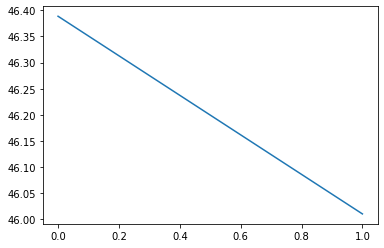

In [22]:
sparse_tls_errors.plot()

/Users/jbrouill/PycharmProjects/eiv-grid-id/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:>

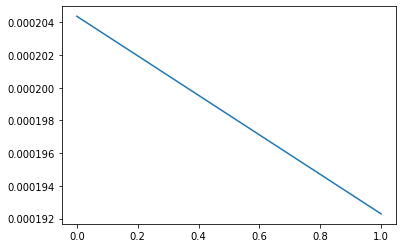

In [23]:
sparse_tls_targets.plot()

# Covariance calculations

Calculates the estimated and real covariance matrices

In [24]:
sigma_power = power_covariance(noisy_voltage.reshape(noisy_voltage.size), noisy_current.reshape(noisy_current.size),
                           voltage_magnitude_sd, phase_sd, current_magnitude_sd, phase_sd)
voltages1 = noisy_voltage.repeat(noisy_voltage.shape[1],1).flatten()
voltages2 = np.tile(noisy_voltage, (1, noisy_voltage.shape[1])).flatten()
sigma_line_mat = power_covariance(voltages1, voltages2, voltage_magnitude_sd, phase_sd, voltage_magnitude_sd, phase_sd)

real_sigma_power = power_covariance(voltage.reshape(voltage.size), current.reshape(current.size),
                           voltage_magnitude_sd, phase_sd, current_magnitude_sd, phase_sd)
voltages1 = voltage.repeat(voltage.shape[1],1).flatten()
voltages2 = np.tile(voltage, (1, voltage.shape[1])).flatten()
real_sigma_line_mat = power_covariance(voltages1, voltages2, voltage_magnitude_sd, phase_sd, voltage_magnitude_sd, phase_sd)


/Users/jbrouill/PycharmProjects/eiv-grid-id/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Inverse covariance matrix

This easily takes 10 minutes, it's the longest cell by far.

In [71]:
inv_sigma_power = sparse.linalg.inv(real_sigma_power)
inv_sigma_line_mat = sparse.linalg.inv(real_sigma_line_mat)

/Users/jbrouill/PycharmProjects/eiv-grid-id/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# L1 Regularized TLS with covariance

In [72]:
with mlflow.start_run(run_name='S-TLS with covariance'):
    max_iterations = 10000
    abs_tol = 10e-7
    rel_tol = 10e-7
    solver = cp.GUROBI
    use_cov_matrix = True

    sparse_tls_cov = SparseTotalLeastSquare(lambda_value=0.0005, abs_tol=abs_tol, rel_tol=rel_tol, solver=solver, max_iterations=max_iterations)
    sparse_tls_cov.fit_with_vectored_data(line_mat, A_mat, b_vector, inv_sigma_line_mat, inv_sigma_power,False,y_tls.conj())

    y_sparse_tls_cov = sparse_tls_cov.fitted_admittance_matrix.conj()
    sparse_tls_cov_metrics = error_metrics(y_bus, y_sparse_tls_cov)

    sparse_tls_cov_errors = pd.Series([fro_error(y_bus.conj(), i.fitted_parameters) for i in sparse_tls_cov.iterations])
    sparse_tls_cov_targets = pd.Series([i.target_function for i in sparse_tls_cov.iterations])

    mlflow.log_param('lambda', best_lambda)
    mlflow.log_param('max_iterations', max_iterations)
    mlflow.log_param('abs_tol', abs_tol)
    mlflow.log_param('rel_tol', rel_tol)
    mlflow.log_param('solver', solver)
    mlflow.log_param('use_cov_matrix', use_cov_matrix)
    mlflow.log_params(mlflow_params)
    mlflow.log_metrics(sparse_tls_cov_metrics.__dict__)

    for i in range(len(sparse_tls_cov_errors)):
        mlflow.log_metric('fro_error_evo', value=sparse_tls_cov_errors[i], step=i)
        mlflow.log_metric('opt_cost_evo', value=sparse_tls_cov_targets[i], step=i)

/Users/jbrouill/PycharmProjects/eiv-grid-id/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/10000 [00:00<?, ?it/s]/Users/jbrouill/PycharmProjects/eiv-grid-id/venv/lib/python3.8/site-packages/cvxpy/reductions/solvers/solving_chain.py:323: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  return self.solver.solve_via_data(data, warm_start, verbose,
100%|██████████| 10000/10000 [2:20:49<00:00,  1.18it/s] 


/Users/jbrouill/PycharmProjects/eiv-grid-id/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:>

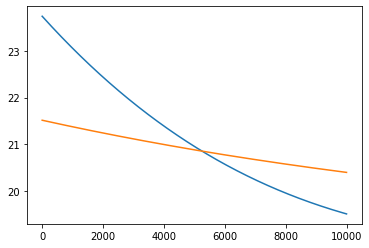

In [73]:
sparse_tls_cov_errors.plot()
sparse_tls_cov_targets.copy().multiply(38).plot()

/Users/jbrouill/PycharmProjects/eiv-grid-id/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:>

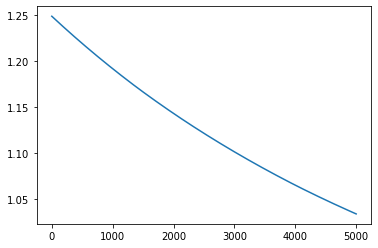

In [48]:
sparse_tls_cov_targets.plot()

# Result analysis

In [ ]:
sns.heatmap(np.abs(y_bus));

In [ ]:
sns.heatmap(np.abs(y_bus - y_ols));

In [ ]:
sns.heatmap(np.abs(y_bus - y_lasso));

/Users/jbrouill/PycharmProjects/eiv-grid-id/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


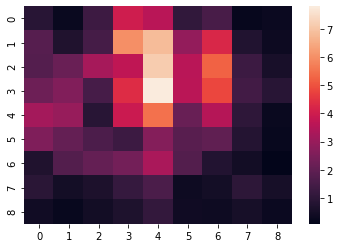

In [59]:
sns.heatmap(np.abs(y_bus - y_tls));

/Users/jbrouill/PycharmProjects/eiv-grid-id/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


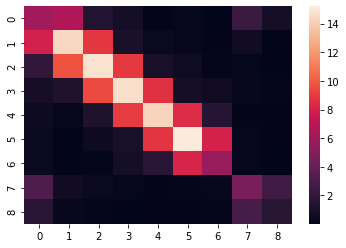

In [74]:
sns.heatmap(np.abs(y_bus - y_sparse_tls));

/Users/jbrouill/PycharmProjects/eiv-grid-id/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


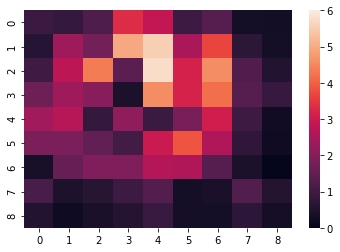

In [75]:
sns.heatmap(np.abs(y_bus - y_sparse_tls_cov),vmin=0,vmax=6);

/Users/jbrouill/PycharmProjects/eiv-grid-id/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


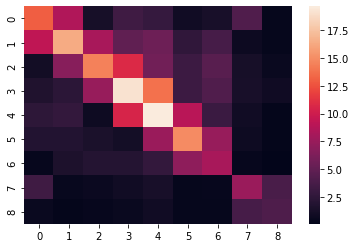

In [76]:
sns.heatmap(np.abs(y_sparse_tls_cov.toarray()));

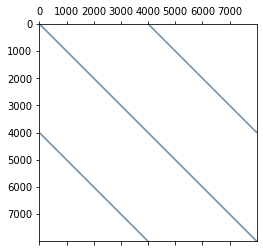

In [37]:
sigma_power.eliminate_zeros()
plt.spy(sigma_power, markersize=0.01)

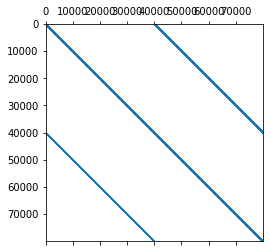

In [38]:
sigma_line_mat.eliminate_zeros()
plt.spy(sigma_line_mat, markersize=0.01)

In [39]:
vals1, vecs1 = sparse.linalg.eigs(inv_sigma_power,k=1000)
plt.plot(vals1)

KeyboardInterrupt: 

In [ ]:
vals2, vecs2 = sparse.linalg.eigs(inv_sigma_line_mat,k=100)
plt.plot(vals2)


In [ ]:
vals1, vecs1 = sparse.linalg.eigs(real_sigma_power,k=1000)
plt.plot(vals1)

In [ ]:
vals2, vecs2 = sparse.linalg.eigs(real_sigma_line_mat,k=100)
plt.plot(vals2)

In [ ]:
sns.heatmap(sigma_line_mat[:400,:400].toarray())

In [ ]:
submat = sigma_line_mat.copy()
submat.setdiag(np.zeros(sigma_line_mat.shape[0]))
submat.eliminate_zeros()

(submat.min(), np.abs(submat).max())

In [ ]:
(sigma_line_mat.min(), sigma_line_mat.max())

In [ ]:
submat = sigma_power.copy()
submat.setdiag(np.zeros(sigma_power.shape[0]))
submat.eliminate_zeros()

(submat.min(), np.abs(submat).max())

In [ ]:
(sigma_power.min(), sigma_power.max())
